### Steane [[7, 1, 3]], circuit model, Steane EC

Depolarization channel: 
$$\rho\rightarrow (1-p)\rho + \frac{p}{3}X\rho X + \frac{p}{3}Y\rho Y + \frac{p}{3}Z\rho Z$$

Assume state prep is FT with 1q-error rate $p$.

During syndrome measurements, faults can propagate through CNOTs and create extra errors. 

For Steane EC, we FT-ly create a logical qubit as the ancilla block and do transversal CNOTs between data and ancilla block. Then we do transversal readout on the ancilla block and apply EC on the data qubit based on the readout. 

CNOTs can be faulty: goes through a 2-qubit depolarization channel with error rate $p$.

Each syndrome measurement has probability $p$ to go wrong.

After circuit-model EC, the success rate of circuit-model EC is determined by applying one round of ideal EC (code capacity). If the ideal EC does not introduce logical error (the output state of the circuit-model EC is correctable), then the circuit-model EC succeeds.

In [294]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
from tqdm import tqdm

In [4]:
def steane_Err():
    # col 1: X error
    # col 2: Z error
    return np.zeros((7, 2))

In [20]:
# Apply depolarization channel, single error rate p
def AddError(p, P_matrix):
    for i in range(7):
        r1 = rand.random()
        if r1 < p:
            r2 = rand.random()
            if r2 < 2/3:
                P_matrix[i][0] = 1
            if 1/3 <= r2 <= 1:
                P_matrix[i][1] = 1
    return P_matrix

In [6]:
# Error occurred during measurement, add to check matrix in each round
def meas_err(p):
    meas_err = np.zeros((2, 3))
    for i in range(2):
        for j in range(3):
            r = np.random.random()
            if r < p:
                meas_err[i][j] = 1
    return meas_err

In [19]:
# CNOT 2-qubit depolarization channel
def CNOT_err(p, logical_1, logical_2, idx_1, idx_2):
    r1 = rand.random()
    if r1 < p*16/15:
        r2 = rand.random()
        r3 = rand.random()
        if r2 < 1/2:                  # X_
            logical_1[idx_1][0] += 1
        if 1/4 <= r2 < 3/4:           # Z_
            logical_1[idx_1][1] += 1
        if r3 < 1/2:                  # _X
            logical_2[idx_2][0] += 1
        if 1/4 <= r3 < 3/4:           # _Z
            logical_2[idx_2][1] += 1
        return 0

In [53]:
# Hook error caused by CNOT
def hook_err(logical_1, logical_2, idx_1, idx_2):
    # logical_1[idx_1]: ctrl
    # logical_2[idx_2]: target
    if logical_1[idx_1][0]%2 == 1:  # X error from ctrl to target
        logical_2[idx_2][0] += 1
    if logical_2[idx_2][1]%2 == 1:  # Z error from target to ctrl
        logical_1[idx_1][1] += 1
    return 0

In [295]:
# Transversal CNOT error propagation
def transversal_CNOT(p, logical_1, logical_2):
    for i in range(len(logical_1)):
        hook_err(logical_1, logical_2, i, i)
        CNOT_err(p, logical_1, logical_2, i, i)
    return 0

In [316]:
def Decoder(Data, Ancilla_X, Ancilla_Z, p=0):
    
    # Introduce errors from syndrome measurement
    transversal_CNOT(p, Data, Ancilla_X)
    transversal_CNOT(p, Ancilla_Z, Data)
    
    # Detect
    H = np.array([[1, 1, 1, 1, 0, 0, 0],
                  [0, 1, 1, 0, 1, 1, 0],
                  [0, 0, 1, 1, 0, 1, 1]]).transpose()
    check_X = (np.dot(Ancilla_X.transpose()[0], H)%2) + meas_err(p)
    check_Z = (np.dot(Ancilla_Z.transpose()[1], H)%2) + meas_err(p)
    
    # Decode
    syndrome_list = np.array([[1, 0, 0],
                              [1, 1, 0],
                              [1, 1, 1],
                              [1, 0, 1],
                              [0, 1, 0],
                              [0, 1, 1],
                              [0, 0, 1]])
    
    # Transversal readout of ancilla blocks, 1 round
    recovery = np.zeros((7, 2))
    for i in range(7):
        if (syndrome_list[i] == check_X).all():
            recovery[i][0] += 1
        if (syndrome_list[i] == check_Z).all():
            recovery[i][1] += 1
    Data = (recovery+Data)%2
    
    # Ideal decoder
    check = (np.dot(Data.transpose(), H)%2)
    recovery_id = np.zeros((7, 2))
    for i in range(7):
        for j in range(2):
            if (syndrome_list[i] == check[j]).all():
                recovery_id[i][j] = 1
    
    return (np.sum((recovery_id+Data)[4:], axis=0)%2)

In [318]:
# Example, adding random error, syndrome
p = 0.2
_Data = AddError(p, steane_Err())
_Ancilla_X = AddError(p, steane_Err())
_Ancilla_Z = AddError(p, steane_Err())
Decoder(_Data, _Ancilla_X, _Ancilla_Z, p)

array([1., 0.])

In [308]:
num_exp = 50000
len_list = 7
# p_list = np.linspace(0, 0.2, len_list)
p_list = np.logspace(-3, -2, len_list)

In [311]:
result_list = np.ones(len_list)*num_exp

for j in (range(len_list)):
    for i in tqdm(range(num_exp)):
        _Data = AddError(p_list[j], steane_Err())
        _Ancilla_X = AddError(p_list[j], steane_Err())
        _Ancilla_Z = AddError(p_list[j], steane_Err())
        if np.sum(Decoder(_Data, _Ancilla_X, _Ancilla_Z, p_list[j])%2) == 0:
            result_list[j] -= 1

result_list /= num_exp

100%|███████████████████████████████████| 50000/50000 [00:08<00:00, 5949.81it/s]


Text(0.5, 1.0, 'Steane [[7, 1, 3]]')

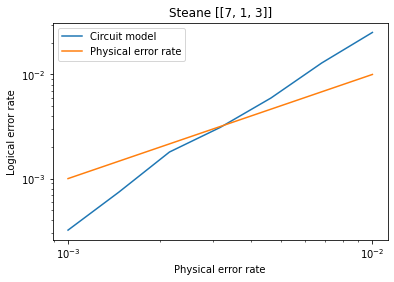

In [325]:
plt.loglog(p_list, result_list, '-', label='Circuit model')
plt.loglog(p_list, p_list, label='Physical error rate')
plt.legend()
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Steane [[7, 1, 3]]')

In [278]:
# result_list